In [122]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import copy
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import datetime
import random

In [123]:
# Define tickers and dates
# List of stock tickers to fetch data for, along with start and end dates for the time range
tickers = [
    "META", "TSLA", "AMZN", "GOOG", "AAPL", "MSFT", "NVDA", "MRNA", "SMCI",
    "ILMN", "MDB", "BIIB", "CDW", "GFS", "WBD", "ON", "ANSS", "DXCM", "ZS",
    "CSGP", "TTWO", "IDXX", "MCHP", "CCEP", "KHC", "CTSH", "EXC", "LULU",
    "VRSK", "XEL", "BKR", "EA", "KDP", "ODFL", "DDOG", "FAST", "ROST", "AEP",
    "PAYX", "FANG", "MNST", "CPRT", "CHTR", "NXPI", "PCAR", "ROP", "TTD", "TEAM",
    "ADSK", "CSX", "ORLY", "WDAY", "FTNT", "DASH", "MAR", "MRVL", "REGN",
    "KLAC", "CDNS", "SNPS", "PYPL", "ABNB", "CRWD", "MDLZ", "CTAS", "LRCX", "MELI",
    "INTC", "ADI", "APP", "MU", "GILD", "SBUX", "VRTX", "ADP", "PANW", "SIRI",
    "AMAT", "HON", "AMGN", "PDD", "CMCSA", "BKNG", "QCOM", "TXN", "INTU", "ISRG",
    "AZN", "LIN", "PEP", "ADBE", "AMD", "CSCO", "ASML", "TMUS", "NFLX", "COST",
    "AVGO", "MSTR", "PLTR"
]
start_date = "2021-10-28"
end_date = "2024-12-09"

# Fetch daily data from yfinance
# Download historical daily stock price data for the defined tickers and date range
data = yf.download(tickers, start=start_date, end=end_date, interval="1d")

# Use Close prices for weekly returns calculation
# Extract the 'Close' price data for further processing
close_data = data['Close']

# Resample Close data to weekly frequency
# Aggregate daily 'Close' prices to their last value for each week ending on Friday
weekly_data = close_data.resample('W-FRI').last()

# Calculate weekly returns
# Compute percentage change in weekly 'Close' prices
weekly_returns = weekly_data.pct_change()
weekly_returns_df = weekly_returns.reset_index()

# Format 'Date' column for readability and set it as the index
weekly_returns_df['Date'] = weekly_returns_df['Date'].dt.strftime('%Y-%m-%d')
weekly_returns_df.set_index('Date', inplace=True)

# Function to calculate factors
# This function generates various technical indicators and features from stock price data
def calculate_factors(df, market_df=None):
    factors = pd.DataFrame(index=df.index)

    # Simple Moving Averages (10, 30) of Close prices
    factors['SMA_10'] = df['Close'].rolling(window=10).mean()
    factors['SMA_30'] = df['Close'].rolling(window=30).mean()

    # Exponential Moving Averages (10, 30)
    factors['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    factors['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()

    # Bollinger Bands (10-day SMA, 2 std deviation)
    # Calculate upper and lower bands based on rolling standard deviation
    rolling_std = df['Close'].rolling(window=10).std()
    factors['BB_Upper'] = factors['SMA_10'] + 2 * rolling_std
    factors['BB_Lower'] = factors['SMA_10'] - 2 * rolling_std

    # Momentum (10 days)
    # Measure the difference between the current 'Close' price and 10-day lagged 'Close'
    factors['Momentum'] = df['Close'] - df['Close'].shift(10)

    # Beta (relative to Nasdaq Index, if provided)
    # Calculate Beta as a measure of stock volatility relative to the market
    if market_df is not None:
        market_returns = market_df['Close'].pct_change()
        stock_returns = df['Close'].pct_change()
        factors['Beta'] = (
            stock_returns.rolling(window=30).cov(market_returns) /
            market_returns.rolling(window=30).var()
        )

    # RSI (14-day)
    # Compute Relative Strength Index to assess overbought/oversold conditions
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    factors['RSI'] = 100 - (100 / (1 + rs))

    # Stochastic Oscillator (14-day)
    # Measure the relative position of the 'Close' price within the 14-day high-low range
    lowest_low = df['Low'].rolling(window=14).min()
    highest_high = df['High'].rolling(window=14).max()
    factors['Stochastic'] = (
        (df['Close'] - lowest_low) / (highest_high - lowest_low)
    ) * 100

    # Money Flow Index (14-day)
    # Calculate MFI as a volume-weighted RSI based on typical price
    if 'Volume' in df.columns:
        typical_price = (df['High'] + df['Low'] + df['Close']) / 3
        money_flow = typical_price * df['Volume']
        positive_flow = money_flow.where(delta > 0, 0).rolling(window=14).sum()
        negative_flow = money_flow.where(delta < 0, 0).rolling(window=14).sum()
        factors['MFI'] = 100 - (100 / (1 + (positive_flow / negative_flow)))

    # Include Open, High, Low, Adj Close, Volume as features
    # Add raw price and volume columns to the factors DataFrame
    factors['Open'] = df['Open']
    factors['High'] = df['High']
    factors['Low'] = df['Low']
    factors['Adj Close'] = df['Adj Close']
    factors['Volume'] = df['Volume']

    return factors

# Calculate factors for each stock
# Process each ticker's data and calculate technical indicators
factors_dict = {}
for ticker in tickers:
    try:
        # Extract data for the specific ticker
        stock_data = data.xs(ticker, level=1, axis=1)
    except KeyError:
        print(f"Data for {ticker} not found. Skipping.")
        continue

    # Calculate factors
    stock_factors = calculate_factors(stock_data)
    factors_dict[ticker] = stock_factors

# Combine factors into a single DataFrame
# Concatenate all calculated factors into a multi-index DataFrame
all_factors = pd.concat(factors_dict, axis=1)
print(all_factors.shape)

[*********************100%***********************]  100 of 100 completed


(782, 1500)


In [124]:
# Fetch historical data
# Use yfinance to download historical stock data for the specified tickers and date range
# Enable progress display to monitor data-fetching status
data = yf.download(tickers, start=start_date, end=end_date, progress=True)

num_day_return = 5  # Define the number of days ahead to calculate returns

# Check if data was fetched successfully
# Raise an error if the data is empty, indicating invalid tickers or date range
if data.empty:
    raise ValueError("No data fetched. Please check the tickers and date range.")

# Extract the 'Close' prices
# Separate handling for single ticker (data['Close'] is a Series) and multiple tickers (data['Close'] is a DataFrame)
if len(tickers) == 1:
    close_prices = data['Close'].to_frame()  # Convert Series to DataFrame for consistency
    open_prices = data['Open'].to_frame()
else:
    close_prices = data['Close']  # For multiple tickers, this is already a DataFrame
    open_prices = data['Open']

# Check if close_prices or open_prices contain any NaN values
# Raise an error if there are missing values in the 'Close' or 'Open' data
if close_prices.isnull().any().any():
    raise ValueError("close_prices contains NaN values. Please check the data.")
if open_prices.isnull().any().any():
    raise ValueError("open_prices contains NaN values. Please check the data.")

# Calculate the target returns
# Weekly returns are computed as:
# (Close price 5 days ahead - Open price of the next trading day) / Open price of the next trading day
print("Calculating weekly returns...")
weekly_returns = (close_prices.shift(-num_day_return) - open_prices.shift(-1)) / open_prices.shift(-1)

# Optionally, multiply by 100 to express returns as percentages
weekly_returns_percentage = weekly_returns * 100

# Optionally, drop the last 5 rows which contain NaN values caused by the shifting operation
weekly_returns_percentage.dropna(how='any', inplace=True)
print(weekly_returns_percentage.shape)  # Print the shape of the resulting DataFrame

[*********************100%***********************]  100 of 100 completed

Calculating weekly returns...
(777, 100)


In [125]:
# Drop rows with any NaN values
all_factors_cleaned = all_factors.dropna(how='any')
print(all_factors_cleaned.shape)

(753, 1500)


In [126]:
# Get all unique factors from the second level of the MultiIndex
factors = all_factors_cleaned.columns.get_level_values(1).unique()
print(factors)

# Initialize a dictionary to store normalized DataFrames for each factor
normalized_factors = {}

# Loop through each factor
for factor in factors:
    # Extract the DataFrame for the current factor
    factor_df = all_factors_cleaned.xs(factor, level=1, axis=1)

    # Calculate the mean and standard deviation for each row
    factor_mean_values = factor_df.mean(axis=1)
    factor_std_values = factor_df.std(axis=1)

    # Perform row-wise normalization
    factor_df_normalized = (factor_df.T - factor_mean_values).T / factor_std_values.values[:, None]

    # Store the normalized DataFrame in the dictionary
    normalized_factors[factor] = factor_df_normalized

Index(['SMA_10', 'SMA_30', 'EMA_10', 'EMA_30', 'BB_Upper', 'BB_Lower',
       'Momentum', 'RSI', 'Stochastic', 'MFI', 'Open', 'High', 'Low',
       'Adj Close', 'Volume'],
      dtype='object')


In [127]:
# Calculate the mean and standard deviation for each row
mean_values = weekly_returns_percentage.mean(axis=1)
std_values = weekly_returns_percentage.std(axis=1)

# Perform row-wise normalization
weekly_returns_normalized = (weekly_returns_percentage.T - mean_values).T / std_values.values[:, None]

# Display the first few rows of the weekly returns DataFrame
print(f"The next {num_day_return}-day returns after normalization (in %):")
print(weekly_returns_normalized.head())

The next 5-day returns after normalization (in %):
Ticker          AAPL      ABNB      ADBE       ADI       ADP      ADSK  \
Date                                                                     
2021-10-28 -0.288134 -0.059041  0.169352  0.133096 -0.388881 -0.498559   
2021-10-29 -0.294205  2.132604 -0.257114  0.404830 -0.161697 -0.242941   
2021-11-01 -0.327662  1.714977  0.084809  0.319399 -0.219201  0.158527   
2021-11-02 -0.342153  1.495483  0.109609  0.223199  0.055798  0.326425   
2021-11-03 -0.471280  1.824340 -0.352392  0.208591  0.350346  0.747836   

Ticker           AEP      AMAT       AMD      AMGN  ...      TSLA       TTD  \
Date                                                ...                       
2021-10-28 -0.797213  0.994604  1.328726 -0.053423  ...  1.328933 -1.076188   
2021-10-29 -0.459077  1.211349  1.535543 -0.114606  ...  0.460144 -1.800368   
2021-11-01 -0.747544  0.969935  2.581834 -0.448776  ... -0.464090  2.050133   
2021-11-02 -0.756815  1.104809  1.9

In [128]:
# Check condition
outliers = (weekly_returns_normalized > 3) | (weekly_returns_normalized < -3)  # Boolean mask
indices = np.argwhere(outliers)  # Get indices of outliers

print("Number of outliers:", np.sum(outliers))
print("Values greater than 3 or less than -3:", weekly_returns_normalized[outliers])

Number of outliers: Ticker
AAPL     0
ABNB     9
ADBE     8
ADI      0
ADP      0
        ..
VRTX     0
WBD     30
WDAY     8
XEL      0
ZS      21
Length: 100, dtype: int64
Values greater than 3 or less than -3: Ticker      AAPL  ABNB  ADBE  ADI  ADP  ADSK  AEP  AMAT  AMD  AMGN  ...  TSLA  \
Date                                                                ...         
2021-10-28   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  ...   NaN   
2021-10-29   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  ...   NaN   
2021-11-01   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  ...   NaN   
2021-11-02   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  ...   NaN   
2021-11-03   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  ...   NaN   
...          ...   ...   ...  ...  ...   ...  ...   ...  ...   ...  ...   ...   
2024-11-22   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  ...   NaN   
2024-11-25   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  N

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [129]:
# Winsorize weekly returns to limit extreme values to the 2nd and 98th percentiles
winsorized_df = weekly_returns_normalized.apply(lambda row: winsorize(row, limits=(0.02, 0.02)), axis=1)

# Convert the winsorized rows back into a DataFrame with the original structure
winsorized_df = pd.DataFrame(
    np.vstack(winsorized_df),
    columns=weekly_returns_normalized.columns,
    index=weekly_returns_normalized.index
)

In [130]:
# Replace weekly_returns_normalized with the winsorized DataFrame
weekly_returns_normalized = winsorized_df

In [131]:
# Check condition
outliers = (winsorized_df > 3) | (winsorized_df < -3)  # Boolean mask
indices = np.argwhere(outliers)  # Get indices of outliers

print("Number of outliers:", np.sum(outliers))
print("Values greater than 3 or less than -3:", winsorized_df[outliers])

Number of outliers: Ticker
AAPL    0
ABNB    3
ADBE    0
ADI     0
ADP     0
       ..
VRTX    0
WBD     2
WDAY    3
XEL     0
ZS      4
Length: 100, dtype: int64
Values greater than 3 or less than -3: Ticker      AAPL  ABNB  ADBE  ADI  ADP  ADSK  AEP  AMAT  AMD  AMGN  ...  TSLA  \
Date                                                                ...         
2021-10-28   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  ...   NaN   
2021-10-29   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  ...   NaN   
2021-11-01   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  ...   NaN   
2021-11-02   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  ...   NaN   
2021-11-03   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  ...   NaN   
...          ...   ...   ...  ...  ...   ...  ...   ...  ...   ...  ...   ...   
2024-11-22   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  ...   NaN   
2024-11-25   NaN   NaN   NaN  NaN  NaN   NaN  NaN   NaN  NaN   NaN  .

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [132]:
# Define window size for rolling calculations
window_size = 60

# Convert dates from normalized_factors to a NumPy array of strings
dates = next(iter(normalized_factors.values())).index.astype(str).to_numpy()

# Initialize a dictionary to store merged DataFrames for each ticker
merged_tickers = {ticker: pd.DataFrame() for ticker in tickers}

# Initialize a dictionary to store rolling window data
rolling_dict = {}

# Merge all factor DataFrames into a single DataFrame for each ticker
for factor, df in normalized_factors.items():
    for ticker in tickers:
        merged_tickers[ticker][factor] = df[ticker]

# Generate rolling windows and organize data into rolling_dict
for ticker, merged_df in merged_tickers.items():
    data = merged_df.to_numpy()  # Convert merged DataFrame to NumPy array
    shape = (data.shape[0] - window_size + 1, window_size, data.shape[1])  # Define shape of rolling windows
    strides = (data.strides[0], data.strides[0], data.strides[1])  # Define strides for rolling windows
    rolling_windows = np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)  # Create rolling windows

    # Organize rolling windows and target values (y) by date
    for i, date in enumerate(dates[window_size-1:]):
        if date in weekly_returns_normalized.index:  # Ensure the date exists in the target DataFrame
            if date not in rolling_dict:
                rolling_dict[date] = {'X': [], 'y': []}

            # Append rolling window data as features (X)
            rolling_dict[date]['X'].append(rolling_windows[i])
            # Append corresponding weekly return as target (y)
            rolling_dict[date]['y'].append(weekly_returns_normalized.loc[date, ticker])

In [133]:
# Convert lists to NumPy arrays for each date
for date in rolling_dict:
    rolling_dict[date]['X'] = np.array(rolling_dict[date]['X'])  # Shape: (num_tickers, window_size, num_factors)
    rolling_dict[date]['y'] = np.array(rolling_dict[date]['y'])  # Shape: (num_tickers,)

In [134]:
print(len(rolling_dict))

689


In [135]:
print(np.array(rolling_dict['2023-10-04']['X']).shape)

(100, 60, 15)


In [136]:
print(np.array(rolling_dict['2023-10-04']['y']).shape)

(100,)


In [137]:
def split_rolling_dict(rolling_dict, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Get all dates in rolling_dict
    dates = list(rolling_dict.keys())

    # Calculate split indices based on train, validation, and test ratios
    total_dates = len(dates)
    train_end = int(total_dates * train_ratio)  # End index for training data
    val_end = train_end + int(total_dates * val_ratio)  # End index for validation data

    # Divide dates into training, validation, and testing sets
    train_dates = dates[:train_end]
    val_dates = dates[train_end:val_end]
    test_dates = dates[val_end:]

    # Extract and split data into train, validation, and test sets
    X_train = [rolling_dict[date]['X'] for date in train_dates]
    y_train = [rolling_dict[date]['y'] for date in train_dates]
    X_val = np.concatenate([rolling_dict[date]['X'] for date in val_dates])  # Combine validation features
    y_val = np.concatenate([rolling_dict[date]['y'] for date in val_dates])  # Combine validation targets
    X_test = np.concatenate([rolling_dict[date]['X'] for date in test_dates])  # Combine test features
    y_test = np.concatenate([rolling_dict[date]['y'] for date in test_dates])  # Combine test targets

    return X_train, y_train, X_val, y_val, X_test, y_test, train_dates, val_dates, test_dates

# Split the rolling_dict into training, validation, and testing datasets
X_train, y_train, X_val, y_val, X_test, y_test, train_dates, val_dates, test_dates = split_rolling_dict(rolling_dict)

In [138]:
print(np.array(X_train).shape)

(482, 100, 60, 15)


In [139]:
print(np.array(y_train).shape)

(482, 100)


In [140]:
print(np.array(X_val).shape)

(10300, 60, 15)


In [141]:
print(np.array(y_val).shape)

(10300,)


In [142]:
print(np.array(X_test).shape)

(10400, 60, 15)


In [143]:
print(np.array(y_test).shape)

(10400,)


In [144]:
class StockDataset(Dataset):
    def __init__(self, x, y):
        # Initialize dataset with input features (x) and target labels (y)
        # Convert inputs and targets to PyTorch tensors with float type
        self.x = list(map(lambda x: torch.tensor(x).float(), x))
        self.y = list(map(lambda x: torch.tensor(x).float(), y))

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.x)

    def __getitem__(self, idx):
        # Retrieve the input features and target labels for the given index
        return self.x[idx], self.y[idx]

In [145]:
# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        # Store GRU layer parameters
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Define GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # Define fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state to zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward pass through GRU
        out, _ = self.gru(x, h0)
        # Use the last hidden state to compute output
        out = self.fc(out[:, -1, :])
        return out

In [146]:
class ConvGRUBranch(nn.Module):
    def __init__(self, num_features, patch_size, embedding_dim, hidden_size, num_layers):
        super(ConvGRUBranch, self).__init__()
        # Store GRU and convolution parameters
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim

        # Define a convolutional layer for patch embedding
        self.conv = nn.Conv1d(in_channels=num_features, out_channels=embedding_dim, kernel_size=patch_size, stride=1)

        # Define a GRU layer
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        # Transpose input for the conv layer: [batch_size, num_features, window_size]
        x = x.transpose(1, 2)

        # Apply convolutional layer for patch embedding
        x = self.conv(x)  # Shape: [batch_size, embedding_dim, num_patches]

        # Transpose back for the GRU: [batch_size, num_patches, embedding_dim]
        x = x.transpose(1, 2)

        # Pass through the GRU
        out, hidden = self.gru(x)

        return out, hidden  # Return GRU outputs and hidden states

In [147]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        # Linear layer to transform keys
        self.attention = nn.Linear(hidden_size, hidden_size)
        # Linear layer to compute context vector
        self.context_vector = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, query, keys, values):
        # query: [batch_size, hidden_size]
        # keys, values: [batch_size, seq_len, hidden_size]

        # Expand query to match keys/values dimensions: [batch_size, 1, hidden_size]
        query = query.unsqueeze(1)

        # Transform keys with tanh activation
        energy = torch.tanh(self.attention(keys))

        # Compute attention scores using batch matrix multiplication
        attention_scores = torch.bmm(query, energy.transpose(1, 2)).squeeze(1)

        # Apply softmax to normalize attention scores
        attention_weights = nn.functional.softmax(attention_scores, dim=1)

        # Compute context vector as weighted sum of values
        context_vector = torch.bmm(attention_weights.unsqueeze(1), values).squeez

In [148]:
class CrossAttentionGRUModel(nn.Module):
    def __init__(self, num_features, patch_size1, patch_size2, embedding_dim, hidden_size, num_layers, output_size):
        super(CrossAttentionGRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim

        # Define two parallel ConvGRU branches with different patch sizes
        self.branch1 = ConvGRUBranch(num_features, patch_size1, embedding_dim, hidden_size, num_layers)
        self.branch2 = ConvGRUBranch(num_features, patch_size2, embedding_dim, hidden_size, num_layers)

        # Define cross-attention layer
        self.attention = Attention(hidden_size)

        # Fully connected layer for final output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Split input into two identical parts for the two branches
        x1, x2 = x, x

        # Forward pass through the first branch
        out1, hidden1 = self.branch1(x1)

        # Forward pass through the second branch
        out2, hidden2 = self.branch2(x2)

        # Apply cross-attention using the last hidden state from branch1 and outputs from branch2
        context_vector, attention_weights = self.attention(hidden1[-1], out2, out2)

        # Pass the context vector through the fully connected layer
        out = self.fc(context_vector)

        return out  # Return the final output

In [149]:
# Define the loss function for Information Coefficient (IC)
class ICLoss(nn.Module):
    def __init__(self):
        super(ICLoss, self).__init__()

    def forward(self, y_pred, y_true):
        # Flatten predictions and true values
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)

        # Calculate means
        y_pred_mean = torch.mean(y_pred)
        y_true_mean = torch.mean(y_true)

        # Compute the numerator for IC calculation
        numerator = torch.sum((y_pred - y_pred_mean) * (y_true - y_true_mean))

        # Compute the denominator for IC calculation
        denominator = torch.sqrt(torch.sum((y_pred - y_pred_mean) ** 2) * torch.sum((y_true - y_true_mean) ** 2))

        # Calculate IC and add epsilon to prevent division by zero
        ic = numerator / (denominator + 1e-8)

        # Return negative IC as loss to maximize IC during training
        return -ic

In [150]:
class GRUTrainer:
    def __init__(self, model, criterion, optimizer, scheduler, device):
        # Initialize trainer with model, loss function, optimizer, scheduler, and device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.model.to(self.device)  # Move model to the specified device
        self.train_losses = []  # List to track training losses
        self.val_losses = []  # List to track validation losses
        self.epochs = 0  # Track the number of epochs completed
        self.models = []  # List to save model states at each epoch

    def fit(self, train_loader, val_loader, num_epochs, early_stop_patience, Loss, ES):
        # Fit the model with training and validation data, applying early stopping
        best_loss = float('inf')
        patience = 0
        best_model_wts = copy.deepcopy(self.model.state_dict())

        for epoch in range(num_epochs):
            self.epochs += 1
            self.model.train()  # Set model to training mode
            train_loss = 0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Forward pass, backward pass, and optimizer step
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)  # Average training loss
            self.train_losses.append(train_loss)
            val_loss, val_mse, _, val_ic_mean, val_ic_std, val_icir = self.evaluate(val_loader)
            self.val_losses.append(val_loss)
            self.models.append(copy.deepcopy(self.model.state_dict()))  # Save model state
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Val MSE: {val_mse:.6f}, Val IC: {val_ic_mean:.6f}, Val IC std: {val_ic_std:.6f}, Val ICIR: {val_icir:.6f}')

            # Scheduler step
            self.scheduler.step(val_loss)

            # Determine the early stopping criteria
            if ES == 'IC':
                val_ESloss = -val_ic_mean
            elif ES == 'MSE':
                val_ESloss = val_mse
            elif ES == 'ICIR':
                val_ESloss = -val_icir

            # Early stopping logic
            if val_ESloss < best_loss:
                best_loss = val_ESloss
                patience = 0
                best_model_wts = copy.deepcopy(self.model.state_dict())
            else:
                patience += 1
                if patience >= early_stop_patience:
                    print(f'Using {ES} as early stop criteria')
                    print("Early stopping")
                    break

        # Load the best model weights
        self.model.load_state_dict(best_model_wts)

    def evaluate(self, val_loader):
        # Evaluate the model on validation data
        self.model.eval()  # Set model to evaluation mode
        val_loss = 0
        all_predictions = []
        all_targets = []
        ic_values = []
        ic_criterion = ICLoss()
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                val_loss += loss.item()

                all_predictions.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
                ic = -ic_criterion(outputs, targets).item()
                ic_values.append(ic)

        val_loss /= len(val_loader)  # Average validation loss
        all_predictions = np.concatenate(all_predictions, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

        # Calculate mean squared error and IC metrics
        mse = mean_squared_error(all_targets, all_predictions)
        if len(ic_values) > 0:
            ic_mean = np.mean(ic_values)
            ic_std = np.std(ic_values)
            icir = ic_mean / ic_std if ic_std != 0 else 0
        else:
            ic_mean = 0
            ic_std = 0
            icir = 0
        return val_loss, mse, ic_values, ic_mean, ic_std, icir

    def predict(self, dataloader):
        # Generate predictions using the trained model
        self.model.eval()  # Set model to evaluation mode
        predictions = []
        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                predictions.append(outputs.cpu().numpy())
        return np.concatenate(predictions, axis=0)

In [182]:
# Create datasets for training, validation, and testing
train_dataset = StockDataset(np.concatenate(X_train), np.concatenate(y_train))  # Combine training data
val_dataset = StockDataset(X_val, y_val)  # Validation data
test_dataset = StockDataset(X_test, y_test)  # Test data

# Define batch size for DataLoader
batch_size = 2000

# Create DataLoader objects for batching and shuffling data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No shuffling for validation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffling for test

In [183]:
# Hyperparameters
input_size = num_factors = 15
hidden_size = 64
num_layers = 2
output_size = 1
patch_size1 = 3
patch_size2 = 5
embedding_dim = 128
learning_rate = 0.0005
num_epochs = 50
early_stop_patience = 5

In [184]:
model = GRUModel(input_size, hidden_size, num_layers, output_size)
#model = CrossAttentionGRUModel(input_size, patch_size1, patch_size2, embedding_dim, hidden_size, num_layers, output_size)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
Loss = 'IC'  # Choose 'MSE' or 'IC'
ES = 'IC'    # Early stopping criterion

if Loss == 'IC':
    criterion = ICLoss()
elif Loss == 'MSE':
    criterion = nn.MSELoss()

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model.to(device)

Using device: cuda


GRUModel(
  (gru): GRU(15, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [185]:
# Initialize the trainer
trainer = GRUTrainer(model, criterion, optimizer, scheduler, device)

# Train the model
trainer.fit(train_loader, val_loader, num_epochs, early_stop_patience, Loss, ES)

Epoch 1/50, Train Loss: -0.015141, Val Loss: -0.056456, Val MSE: 0.723875, Val IC: 0.056456, Val IC std: 0.110732, Val ICIR: 0.509849
Epoch 2/50, Train Loss: -0.036616, Val Loss: -0.079097, Val MSE: 0.718448, Val IC: 0.079097, Val IC std: 0.120527, Val ICIR: 0.656254
Epoch 3/50, Train Loss: -0.036265, Val Loss: -0.056260, Val MSE: 0.731267, Val IC: 0.056260, Val IC std: 0.113893, Val ICIR: 0.493972
Epoch 4/50, Train Loss: -0.034634, Val Loss: -0.057749, Val MSE: 0.729402, Val IC: 0.057749, Val IC std: 0.110423, Val ICIR: 0.522975
Epoch 5/50, Train Loss: -0.046722, Val Loss: -0.059852, Val MSE: 0.722626, Val IC: 0.059852, Val IC std: 0.105472, Val ICIR: 0.567465
Epoch 6/50, Train Loss: -0.040766, Val Loss: -0.064536, Val MSE: 0.718186, Val IC: 0.064536, Val IC std: 0.108113, Val ICIR: 0.596936
Epoch 7/50, Train Loss: -0.046714, Val Loss: -0.035347, Val MSE: 0.724776, Val IC: 0.035347, Val IC std: 0.078634, Val ICIR: 0.449510
Using IC as early stop criteria
Early stopping


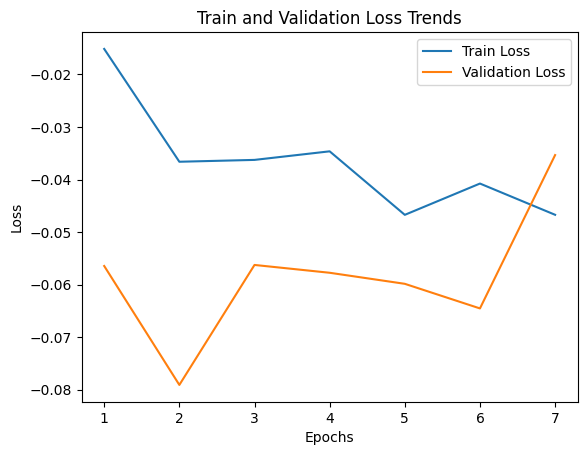

In [186]:
# Plot training and validation loss trends over epochs
epochs = list(range(1, trainer.epochs + 1))  # Generate list of epoch numbers
plt.plot(epochs, trainer.train_losses, label='Train Loss')  # Plot training loss
plt.plot(epochs, trainer.val_losses, label='Validation Loss')  # Plot validation loss
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Loss')  # Label for y-axis
plt.title('Train and Validation Loss Trends')  # Title of the plot
plt.legend()  # Add legend to differentiate between training and validation loss
plt.show()  # Display the plot

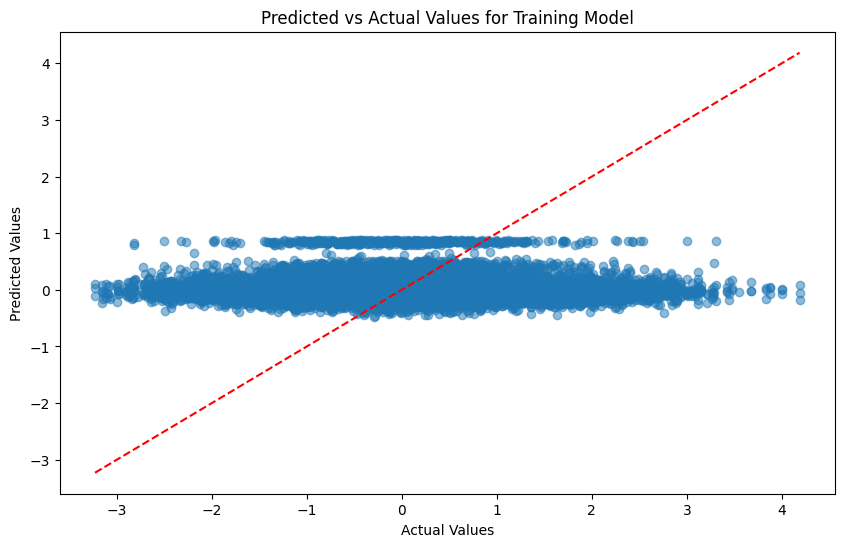

In [187]:
# Prepare actual and predicted values for training data
actuals_train = np.concatenate(y_train, axis=0)  # Combine actual target values
predictions_train = trainer.predict(train_loader)  # Get predictions from the model

# Create a scatter plot to compare actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actuals_train, predictions_train, alpha=0.5)  # Scatter plot with transparency
plt.plot([actuals_train.min(), actuals_train.max()], [actuals_train.min(), actuals_train.max()], 'r--')  # Diagonal reference line
plt.xlabel('Actual Values')  # Label for x-axis
plt.ylabel('Predicted Values')  # Label for y-axis
plt.title('Predicted vs Actual Values for Training Model')  # Title of the plot
plt.show()  # Display the plot

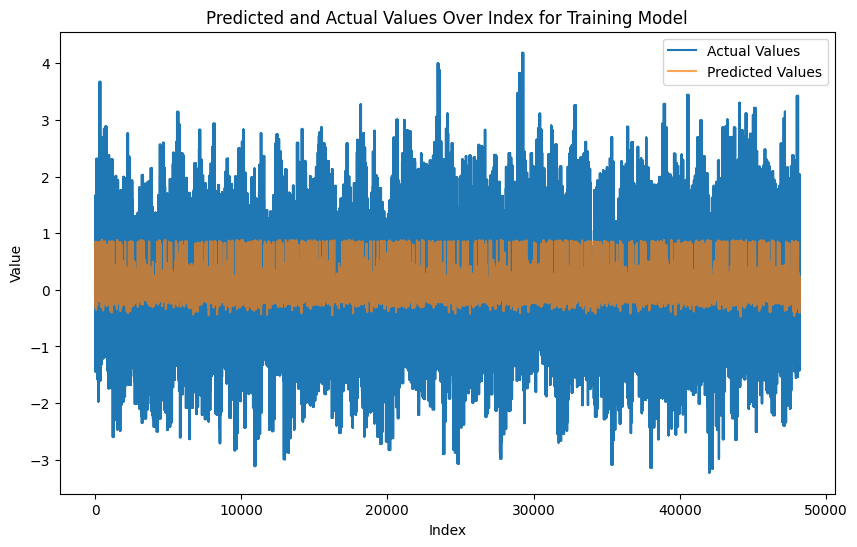

In [188]:
# Plotting the predictions and actual values over the index
plt.figure(figsize=(10, 6))
plt.plot(actuals_train, label='Actual Values')
plt.plot(predictions_train, label='Predicted Values', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted and Actual Values Over Index for Training Model')
plt.legend()
plt.show()

In [189]:
# Evaluating the model on the validation set
val_loss, val_mse, val_ic_values, val_ic_mean, val_ic_std, val_icir = trainer.evaluate(val_loader)
print(f'Validation Loss: {val_loss:.4f}, Validation MSE: {val_mse:.4f}, Validation IC: {val_ic_mean:.4f}, Validation IC std: {val_ic_std:.4f}, Validation ICIR: {val_icir:.4f}')

Validation Loss: -0.0791, Validation MSE: 0.7184, Validation IC: 0.0791, Validation IC std: 0.1205, Validation ICIR: 0.6563


In [190]:
val_ic_values

[0.058210186660289764,
 -0.029087569564580917,
 0.02539687231183052,
 0.05974106118083,
 0.019948219880461693,
 0.3403707444667816]

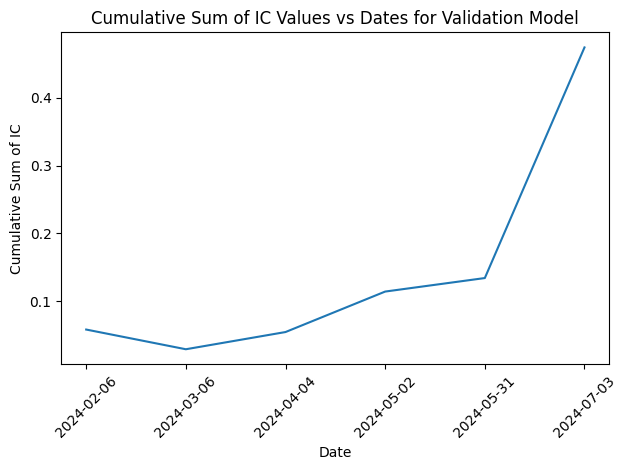

In [191]:
# Calculate step size for indexing IC values and corresponding validation dates
step = len(val_dates) // (len(val_ic_values) - 1)
indices = [i * step for i in range(len(val_ic_values) - 1)] + [len(val_dates) - 1]  # Create indices for dates

# Plot cumulative sum of IC values against corresponding dates
plt.plot([val_dates[i] for i in indices], np.cumsum(val_ic_values))  # Plot cumulative sum of IC values
plt.xlabel('Date')  # Label for x-axis
plt.ylabel('Cumulative Sum of IC')  # Label for y-axis
plt.title('Cumulative Sum of IC Values vs Dates for Validation Model')  # Title of the plot
plt.xticks(rotation=45)  # Rotate x-axis ticks for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot




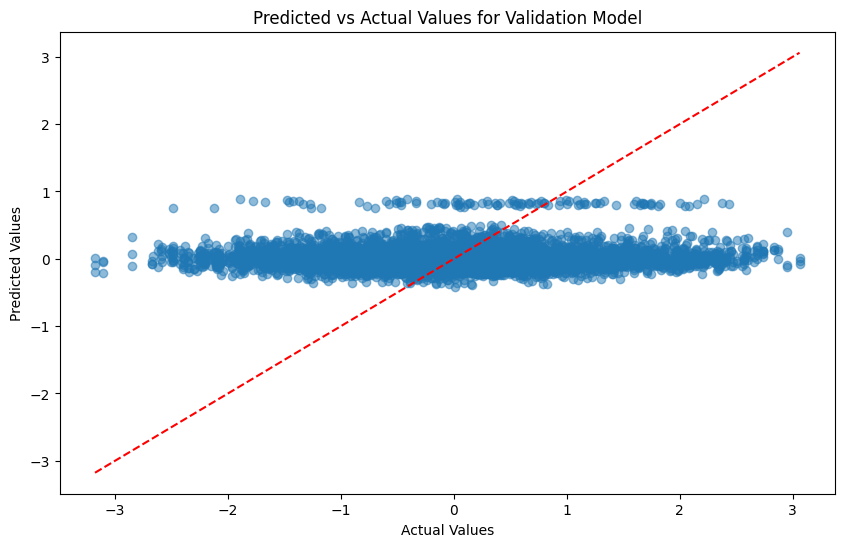

In [192]:
# Prepare actual and predicted values for validation data
actuals_val = y_val  # Actual target values for validation data
predictions_val = trainer.predict(val_loader)  # Predictions from the model for validation data

# Create a scatter plot to compare actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actuals_val, predictions_val, alpha=0.5)  # Scatter plot with transparency
plt.plot([actuals_val.min(), actuals_val.max()], [actuals_val.min(), actuals_val.max()], 'r--')  # Diagonal reference line
plt.xlabel('Actual Values')  # Label for x-axis
plt.ylabel('Predicted Values')  # Label for y-axis
plt.title('Predicted vs Actual Values for Validation Model')  # Title of the plot
plt.show()  # Display the plot

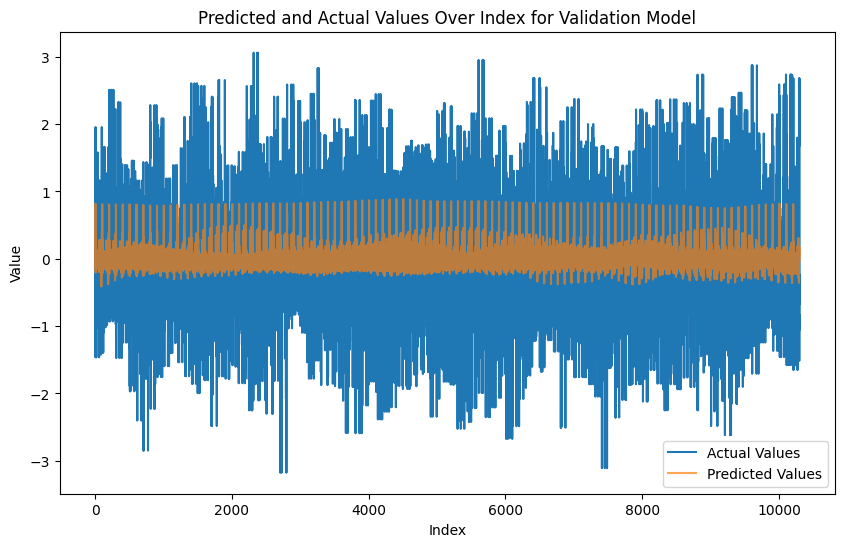

In [193]:
# Plotting the predictions and actual values over the index
plt.figure(figsize=(10, 6))
plt.plot(actuals_val, label='Actual Values')
plt.plot(predictions_val, label='Predicted Values', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted and Actual Values Over Index for Validation Model')
plt.legend()
plt.show()

In [194]:
# Evaluating the model on the test set
test_loss, test_mse, test_ic_values, test_ic_mean, test_ic_std, test_icir = trainer.evaluate(test_loader)
print(f'Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}, Test IC: {test_ic_mean:.4f}, Test IC std: {test_ic_std:.4f}, Test ICIR: {test_icir:.4f}')

Test Loss: -0.0667, Test MSE: 0.7086, Test IC: 0.0667, Test IC std: 0.1099, Test ICIR: 0.6066


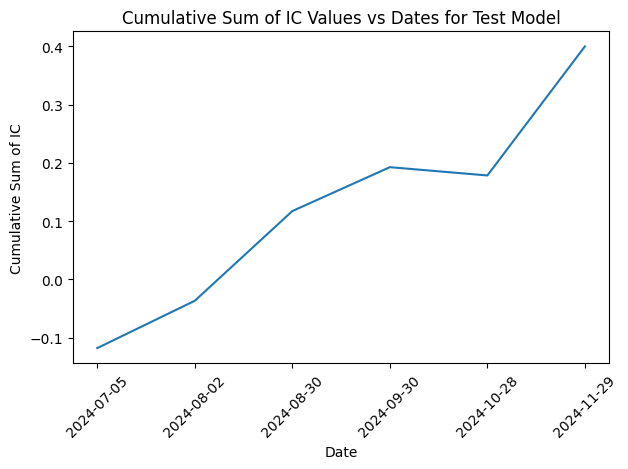

In [195]:
# Calculate step size for indexing IC values and corresponding test dates
step = len(test_dates) // (len(test_ic_values) - 1)
indices = [i * step for i in range(len(test_ic_values) - 1)] + [len(test_dates) - 1]  # Create indices for dates

# Plot cumulative sum of IC values against corresponding test dates
plt.plot([test_dates[i] for i in indices], np.cumsum(test_ic_values))  # Plot cumulative sum of IC values
plt.xlabel('Date')  # Label for x-axis
plt.ylabel('Cumulative Sum of IC')  # Label for y-axis
plt.title('Cumulative Sum of IC Values vs Dates for Test Model')  # Title of the plot
plt.xticks(rotation=45)  # Rotate x-axis ticks for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

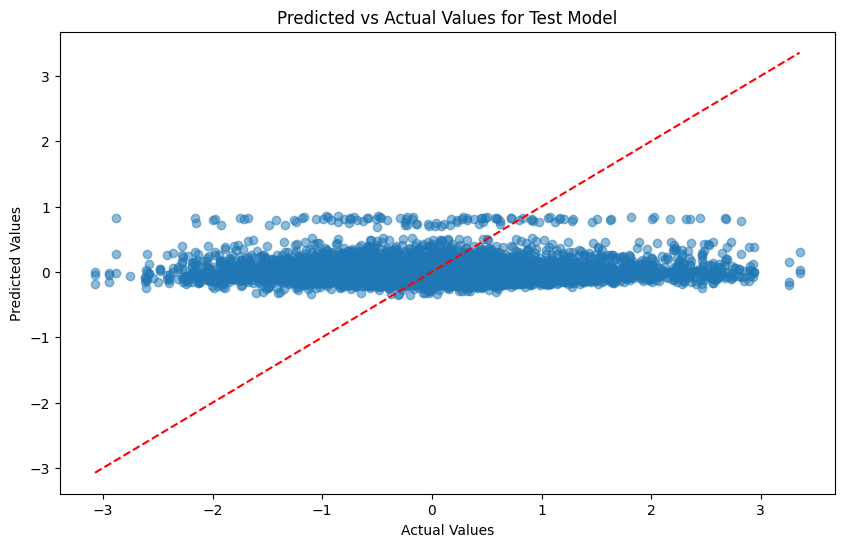

In [196]:
# Prepare actual and predicted values for test data
actuals_test = y_test  # Actual target values for test data
predictions_test = trainer.predict(test_loader)  # Predictions from the model for test data

# Create a scatter plot to compare actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actuals_test, predictions_test, alpha=0.5)  # Scatter plot with transparency
plt.plot([actuals_test.min(), actuals_test.max()], [actuals_test.min(), actuals_test.max()], 'r--')  # Diagonal reference line
plt.xlabel('Actual Values')  # Label for x-axis
plt.ylabel('Predicted Values')  # Label for y-axis
plt.title('Predicted vs Actual Values for Test Model')  # Title of the plot
plt.show()  # Display the plot

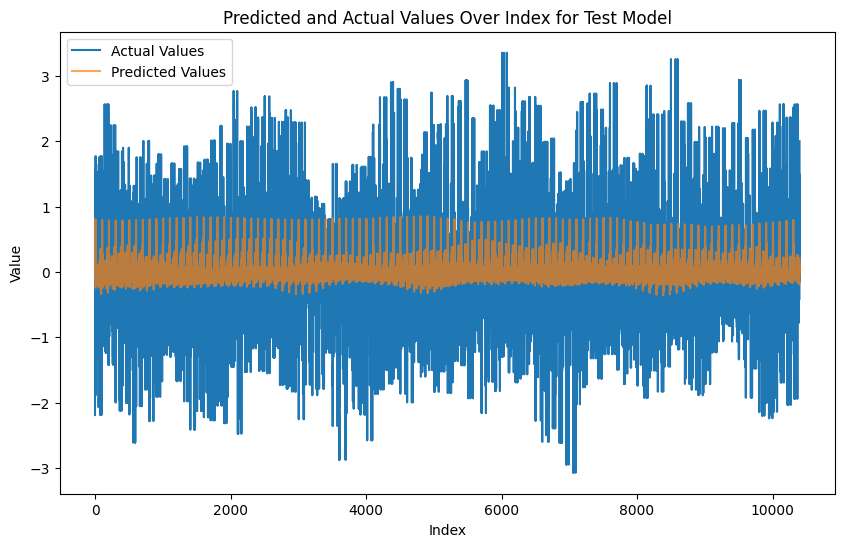

In [197]:
# Plotting the predictions and actual values over the index
plt.figure(figsize=(10, 6))
plt.plot(actuals_test, label='Actual Values')
plt.plot(predictions_test, label='Predicted Values', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted and Actual Values Over Index for Test Model')
plt.legend()
plt.show()

In [198]:
# Set the test date for specific analysis
date_test = '2024-10-18'

In [199]:
# Set the device for computation (use GPU if available, else fallback to CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the specified device and set to evaluation mode
model = model.to(device)
model.eval()

# Prepare input data for the test date
input_data = []
for ticker, merged_df in merged_tickers.items():
    # Get the end index for the test date
    end_index = merged_df.index.get_loc(date_test)
    # Extract the rolling window data for the test date
    input_data.append(merged_df.iloc[end_index - window_size + 1: end_index + 1].to_numpy())

# Convert input data to a PyTorch tensor and move to the device
input_data = torch.tensor(input_data).float().to(device)

# Predict returns for the test date
with torch.no_grad():
    predicted_returns = model(input_data)

In [200]:
# Convert PyTorch tensor of predicted returns to a NumPy array
predicted_returns_np = predicted_returns.flatten().cpu().numpy()  # Flatten tensor, move to CPU, and convert to NumPy
predicted_returns_np  # Output the converted NumPy array

array([ 0.01883061,  0.43288952,  0.0661341 ,  0.11943706,  0.14722016,
        0.06772798,  0.82183397,  0.04266484,  0.05576577, -0.1388942 ,
       -0.13500878, -0.12889805,  0.00356904,  0.00107604,  0.08821614,
        0.06000939, -0.08872244, -0.1532273 , -0.14474192,  0.01992177,
        0.00843066,  0.10373563,  0.07725467,  0.0082392 ,  0.03737299,
       -0.01906206,  0.04453493, -0.09848081,  0.0522068 ,  0.03125117,
        0.02900225,  0.01197561,  0.01996419, -0.05167657, -0.09970429,
       -0.16113076, -0.04583386, -0.03476087, -0.17714223, -0.03814932,
       -0.03958318, -0.02744384, -0.01481504,  0.01575201, -0.1321255 ,
       -0.0506842 , -0.08216453, -0.11625556, -0.0416756 ,  0.04330299,
       -0.16670457, -0.02100175, -0.07132997, -0.09277739, -0.11557027,
       -0.00300695,  0.19273752,  0.09095662, -0.04776474, -0.06892661,
       -0.06044407, -0.1162953 , -0.11611877, -0.00508173, -0.11467601,
        0.06021785,  0.09265045,  0.1638256 , -0.06165201, -0.06

In [201]:
# Assign ranks to predicted returns based on quantiles
num_classes = 10  # Number of quantiles
ranks = pd.qcut(predicted_returns_np, num_classes, labels=False) + 1  # Ranks from 1 to num_classes

# Print the assigned ranks
print("Assigned Ranks:", ranks)

Assigned Ranks: [ 7 10  9 10 10  9 10  8  8  1  1  2  6  6  9  8  3  1  1  7  6  9  9  6
  8  5  8  3  8  7  7  6  7  4  2  1  4  5  1  5  4  5  5  6  1  4  3  2
  4  8  1  5  3  3  2  5 10  9  4  3  4  2  2  5  2  8  9 10  4  4  7  8
  7  2  3  3  9  6  1  3  9  7 10  2  9  7  6  8  1  5  7 10  6 10  3  4
  5  6  2 10]


In [202]:
# Filter weekly returns for Fridays only, starting from a specific date
friday_weekly_returns_percentage = weekly_returns_percentage[
    (weekly_returns_percentage.index.weekday == 4) &  # Select only Fridays
    (weekly_returns_percentage.index >= '2024-07-05')  # Filter for dates from '2024-07-05' onwards
]

# Display the filtered DataFrame
friday_weekly_returns_percentage

Ticker,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,TSLA,TTD,TTWO,TXN,VRSK,VRTX,WBD,WDAY,XEL,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-05,1.519220,-3.845395,-2.465195,2.747870,1.078652,2.986587,3.481226,0.119285,3.836482,6.253212,...,0.209918,-0.500100,0.994474,0.929954,1.270541,3.327693,1.788172,1.549605,3.410168,0.562828
2024-07-12,-5.146312,1.446395,-1.647534,-2.496415,3.686132,-4.294795,3.604002,-14.011128,-17.820545,-0.177774,...,-6.551551,-3.797596,-2.103547,-1.367282,-0.198291,0.638754,18.119890,-1.391414,4.229552,-6.962744
2024-07-19,-3.986603,-5.427294,-2.901642,-4.508267,1.404663,-1.882025,3.221313,-4.513710,-9.232958,0.486149,...,-9.995497,-5.942807,0.126197,-0.546529,0.538658,-0.350099,-3.930627,-0.122313,2.082225,-5.076938
2024-07-26,1.336649,-9.211278,-3.330885,-9.084549,3.544200,-4.609362,5.339960,-12.717237,-6.154828,-0.026939,...,-7.661181,-10.733854,-5.105350,-7.777831,-4.886568,-0.133302,0.121068,-6.022833,3.750651,-7.117413
2024-08-02,8.614199,-7.021083,6.360188,2.562733,-1.970469,6.060876,-6.437068,9.145917,9.913229,-3.074661,...,7.979699,28.427320,2.592805,4.116790,-3.149865,-0.236388,-10.559795,5.980295,-6.365109,11.405026
2024-08-09,4.618871,0.718734,3.249766,5.203869,1.191657,3.355955,-0.564156,8.563965,10.502823,-0.759491,...,8.592097,1.745409,2.776066,4.198494,1.561729,2.229314,6.772331,9.337112,3.664015,10.228568
2024-08-16,0.496188,-0.068419,1.400309,2.679498,1.878094,2.720320,1.101049,-2.091788,4.412857,2.283331,...,1.497213,3.550294,6.260000,4.657431,0.528606,0.886770,8.198926,13.051235,0.216698,3.224636
2024-08-23,0.987831,0.393666,3.491693,3.072332,1.981155,0.572141,1.703854,-1.699309,-3.968972,1.650371,...,-2.121143,-0.162367,1.106668,2.555022,1.480439,2.886013,-3.209879,1.226924,0.723801,-0.059975
2024-08-30,-3.342813,-0.030067,-1.114000,-4.429579,0.948717,-2.330287,3.463421,-8.043297,-5.641698,-1.798789,...,0.469205,-4.435678,-2.755827,-5.086105,0.150273,-4.372274,-6.410256,-3.600892,3.724886,-20.416021


In [203]:
# Ensure the lengths of tickers and ranks match
if len(tickers) != len(ranks):
    raise ValueError("The number of tickers and ranks do not match!")

# Create a DataFrame pairing tickers with ranks and predicted returns
ranked_tickers = pd.DataFrame({
    "Ticker": tickers,
    "Rank": ranks,
    "Predicted Return": predicted_returns_np
})

# Map actual returns for the test date to the ranked tickers
actual_returns = friday_weekly_returns_percentage.loc[date_test]
ranked_tickers['Actual Return'] = ranked_tickers['Ticker'].map(actual_returns)

# Display the resulting DataFrame
ranked_tickers

,Ticker,Rank,Predicted Return,Actual Return
0,META,7,0.018831,-0.482619
1,TSLA,10,0.432890,22.973965
2,AMZN,9,0.066134,-0.116991
3,GOOG,10,0.119437,1.464336
4,AAPL,10,0.147220,-1.296649
...,...,...,...,...
95,NFLX,4,-0.046738,-1.446931
96,COST,5,-0.008516,0.249715
97,AVGO,6,0.006011,-3.556698
98,MSTR,2,-0.119826,9.254506


In [204]:
# Filter for Rank 10 and Rank 1
rank10_tickers = ranked_tickers[ranked_tickers['Rank'] == 10].sort_values(by='Predicted Return', ascending=False)
rank1_tickers = ranked_tickers[ranked_tickers['Rank'] == 1].sort_values(by='Predicted Return', ascending=True)

# Display results
print("\nRank 10 Tickers Sorted by Predicted Return:")
print(rank10_tickers)

print("Rank 1 Tickers Sorted by Predicted Return:")
print(rank1_tickers)


Rank 10 Tickers Sorted by Predicted Return:
   Ticker  Rank  Predicted Return  Actual Return
6    NVDA    10          0.821834       2.468680
1    TSLA    10          0.432890      22.973965
93   ASML    10          0.222227      -1.698893
91    AMD    10          0.202487       0.301747
56   REGN    10          0.192738      -5.363628
67   INTC    10          0.163826       0.309596
4    AAPL    10          0.147220      -1.296649
99   PLTR    10          0.146510       4.666356
3    GOOG    10          0.119437       1.464336
82   BKNG    10          0.115697       0.568784
Rank 1 Tickers Sorted by Predicted Return:
   Ticker  Rank  Predicted Return  Actual Return
38   PAYX     1         -0.177142      -0.952845
50   ORLY     1         -0.166705      -1.584242
78    HON     1         -0.163574      -6.293644
35   FAST     1         -0.161131      -2.594072
17   DXCM     1         -0.153227       2.184499
18     ZS     1         -0.144742      -1.909202
88    LIN     1         -0.141

In [205]:
# Download historical data for QQQ
qqq_data = yf.download('QQQ', start=start_date, end=end_date, progress=True)

# Calculate weekly returns for QQQ
# Weekly return = (Close price 5 days ahead - Open price of the next trading day) / Open price of the next trading day
qqq_weekly_returns = (qqq_data['Close'].shift(-num_day_return) - qqq_data['Open'].shift(-1)) / qqq_data['Open'].shift(-1)

# Convert returns to percentage
qqq_weekly_returns_percentage = qqq_weekly_returns * 100

# Drop rows with NaN values (caused by shifting)
qqq_weekly_returns_percentage.dropna(how='any', inplace=True)

# Print the shape of the cleaned returns DataFrame
print(qqq_weekly_returns_percentage.shape)

[*********************100%***********************]  1 of 1 completed

(777, 1)


In [206]:
# Filter QQQ weekly returns for Fridays only, starting from a specific date
qqq_friday_weekly_returns_percentage = qqq_weekly_returns_percentage[
    (qqq_weekly_returns_percentage.index.weekday == 4) &  # Select only Fridays
    (qqq_weekly_returns_percentage.index >= '2024-07-05')  # Filter for dates from '2024-07-05' onwards
]

# Display the filtered QQQ weekly returns for Fridays
qqq_friday_weekly_returns_percentage

Ticker,QQQ
Date,
2024-07-05,-0.344388
2024-07-12,-4.303175
2024-07-19,-3.780448
2024-07-26,-3.641750
2024-08-02,6.051191
2024-08-09,5.237153
2024-08-16,1.016475
2024-08-23,-0.663265
2024-08-30,-3.960275


In [207]:
# Group by rank and assign equal weights
ranked_tickers['Weight'] = ranked_tickers.groupby('Rank')['Predicted Return'].transform(lambda x: 1 / len(x))

benchmark_return = qqq_friday_weekly_returns_percentage.loc[date_test].loc['QQQ']
print(f'benchmark_return for {date_test}', benchmark_return)

# Sharpe-like Ratio Calculation
group_sharpe_ratios = []
for rank, group in ranked_tickers.groupby('Rank'):
    print(rank)
    # Weighted actual return for the group
    weighted_actual_return = (group['Actual Return'] * group['Weight']).sum()
    print('weighted_actual_return', weighted_actual_return)
    # Portfolio volatility for the group
    portfolio_std = group['Actual Return'].std()
    print('portfolio_std', portfolio_std)
    # Sharpe-like ratio for the group
    sharpe_ratio = (weighted_actual_return - benchmark_return) / portfolio_std if portfolio_std > 0 else 0
    print('sharpe_ratio', sharpe_ratio)
    group_sharpe_ratios.append({'Rank': rank, 'Sharpe-like Ratio': sharpe_ratio})

# Convert to DataFrame
sharpe_ratios_df = pd.DataFrame(group_sharpe_ratios)
sharpe_ratios_df

benchmark_return for 2024-10-18 0.4196669689242271
1
weighted_actual_return -2.0676041883521763
portfolio_std 2.1200059846843233
sharpe_ratio -1.173237799914403
2
weighted_actual_return -0.2977268609677157
portfolio_std 3.688355157345304
sharpe_ratio -0.19450237281604074
3
weighted_actual_return 0.07579916364507608
portfolio_std 2.1728332032349083
sharpe_ratio -0.15825780127402397
4
weighted_actual_return 0.2832983277263068
portfolio_std 3.5071761300331152
sharpe_ratio -0.03888274672895675
5
weighted_actual_return -1.290126502950718
portfolio_std 2.310753212467629
sharpe_ratio -0.7399290684309273
6
weighted_actual_return 0.3776263206507122
portfolio_std 2.727045805738295
sharpe_ratio -0.015416187064057472
7
weighted_actual_return -1.3877800801316997
portfolio_std 2.734963023606358
sharpe_ratio -0.6608670879479035
8
weighted_actual_return -0.0317063162804988
portfolio_std 3.6311094483028574
sharpe_ratio -0.1243072652122048
9
weighted_actual_return -0.3022769127189652
portfolio_std 2.959

,Rank,Sharpe-like Ratio
0,1,-1.173238
1,2,-0.194502
2,3,-0.158258
3,4,-0.038883
4,5,-0.739929
5,6,-0.015416
6,7,-0.660867
7,8,-0.124307
8,9,-0.243970
9,10,0.262665


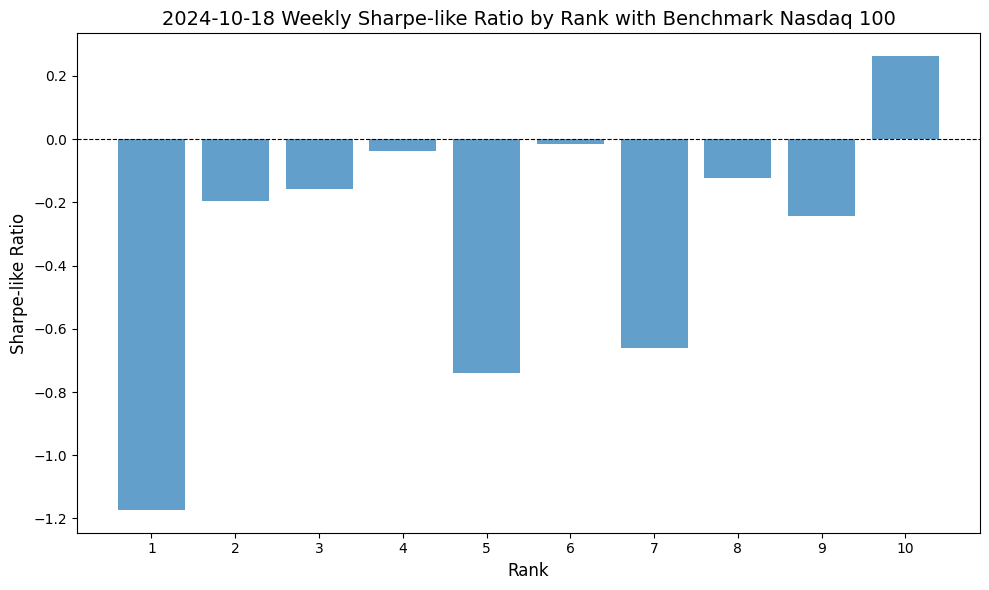

In [208]:
# Create a bar plot for Sharpe-like Ratios by rank
plt.figure(figsize=(10, 6))
plt.bar(sharpe_ratios_df["Rank"], sharpe_ratios_df["Sharpe-like Ratio"], alpha=0.7)  # Bar plot for ratios
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a baseline at 0
plt.xlabel("Rank", fontsize=12)  # Label for x-axis
plt.ylabel("Sharpe-like Ratio", fontsize=12)  # Label for y-axis
plt.title(f"{date_test} Weekly Sharpe-like Ratio by Rank with Benchmark Nasdaq 100", fontsize=14)  # Plot title
plt.xticks(sharpe_ratios_df["Rank"], fontsize=10)  # Format x-ticks
plt.yticks(fontsize=10)  # Format y-ticks
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

In [213]:
# Mount Google Drive to access files
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [210]:
#torch.save(trainer.model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/gru_model.pth')

In [214]:
# Hyperparameters
input_size = num_factors = 15
hidden_size = 64
num_layers = 2
output_size = 1
patch_size1 = 3
patch_size2 = 5
embedding_dim = 128
learning_rate = 0.0005
num_epochs = 50
early_stop_patience = 5

In [215]:
# Initialize the GRU model
model = GRUModel(input_size, hidden_size, num_layers, output_size)

# Load the saved model state from a file in Google Drive
model.load_state_dict(torch.load(f'/content/drive/MyDrive/Colab Notebooks/gru.pth'))

<ipython-input-215-b12d994b5c2f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/content/drive/MyDrive/Colab Notebooks/gru.pth'))


<All keys matched successfully>

In [216]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)  # Print the device being used

# Move the model to the selected device
model.to(device)

# Initialize a GRUTrainer instance for testing with the loaded model
tester = GRUTrainer(model, ICLoss(), None, None, device)

cuda


In [217]:
# Evaluate the model on the test dataset
test_loss, test_mse, test_ic_values, test_ic_mean, test_ic_std, test_icir = tester.evaluate(test_loader)

# Print the evaluation metrics for the test dataset
print(f'Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}, Test IC: {test_ic_mean:.4f}, Test IC std: {test_ic_std:.4f}, Test ICIR: {test_icir:.4f}')

Test Loss: -0.0774, Test MSE: 0.7040, Test IC: 0.0774, Test IC std: 0.1142, Test ICIR: 0.6777
